In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
device = 'cuda'

In [8]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [9]:
def MARE_np(prediction, truth):
    epsilon = 1e-8  # Small value to prevent division by zero
    return np.sum((np.abs(prediction - truth)) / np.abs(truth + epsilon)) / len(truth)

In [10]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [11]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('1min').mean()

In [12]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [13]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """
    target_length = seq_length // 3  # Target is 1/3 the size of the training sequence

    if len(data) < seq_length + target_length:
        raise ValueError("Data length must be at least seq_length + target_length.")

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length - target_length + 1):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length:i+seq_length+target_length]) # Target sequence

    return np.array(sequences), np.array(targets)


In [14]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 90)


# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device=device) # (batch, output_dim)

# data piece 2
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2


# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 90)


# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device=device) # (batch, output_dim)

# data piece 3
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece


# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 90)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device=device) # (batch, output_dim)

# data piece 4
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 90)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device=device) # (batch, output_dim)


In [15]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 90)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device=device)
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device=device)

normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 90)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device=device)
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device=device)

normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 90)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 90)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

test_labels_1_un = test_labels_1 * first_piece.std().values + first_piece.mean().values
test_labels_2_un = test_labels_2 * second_piece.std().values + second_piece.mean().values
test_labels_3_un = test_labels_3 * third_piece.std().values + third_piece.mean().values
test_labels_4_un = test_labels_4 * fourth_piece.std().values + fourth_piece.mean().values

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 30)
        # self.fc2 = nn.Linear(30, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        # print(out.shape)
        out = self.fc1(out[:,-1, :]) # take the last hidden state because we assume it encodes all the information about the sequence
        # out = self.fc2(out[, :])  # Take the last 30 time step output
        return out.unsqueeze(2)

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

torch.manual_seed(42)
# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cuda")  # Use "cuda" if you have a GPU
torch.manual_seed(42)
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cuda")  # Use "cuda" if you have a GPU
torch.manual_seed(42)
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
criterion3 = nn.SmoothL1Loss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

### Train models 1, 2, 3

In [17]:
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.4783779978752136
Epoch 10, Train Loss: 0.4753434956073761
Epoch 20, Train Loss: 0.4674391448497772
Epoch 30, Train Loss: 0.4318515956401825
Epoch 40, Train Loss: 0.2707573175430298
Epoch 50, Train Loss: 0.17363795638084412
Epoch 60, Train Loss: 0.130163311958313
Epoch 70, Train Loss: 0.1158125102519989
Epoch 80, Train Loss: 0.09714887291193008
Epoch 90, Train Loss: 0.08358844369649887
Epoch 100, Train Loss: 0.07416834682226181
Epoch 110, Train Loss: 0.06857936829328537
Epoch 120, Train Loss: 0.0651521161198616
Epoch 130, Train Loss: 0.062423255294561386
Epoch 140, Train Loss: 0.05998631939291954
Epoch 150, Train Loss: 0.05767514929175377
Epoch 160, Train Loss: 0.055317994207143784
Epoch 170, Train Loss: 0.052738599479198456
Epoch 180, Train Loss: 0.049704402685165405
Epoch 190, Train Loss: 0.04572592303156853
Epoch 200, Train Loss: 0.039890389889478683
Epoch 210, Train Loss: 0.036315787583589554
Epoch 220, Train Loss: 0.03492087870836258
Epoch 230, Train Loss: 0.

In [18]:

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.47595566511154175
Epoch 10, Train Loss: 0.47315648198127747
Epoch 20, Train Loss: 0.46556615829467773
Epoch 30, Train Loss: 0.4320449233055115
Epoch 40, Train Loss: 0.25820955634117126
Epoch 50, Train Loss: 0.13331331312656403
Epoch 60, Train Loss: 0.10100923478603363
Epoch 70, Train Loss: 0.08269467949867249
Epoch 80, Train Loss: 0.06095331907272339
Epoch 90, Train Loss: 0.04979470372200012
Epoch 100, Train Loss: 0.04579707235097885
Epoch 110, Train Loss: 0.04446949437260628
Epoch 120, Train Loss: 0.043195661157369614
Epoch 130, Train Loss: 0.04217256233096123
Epoch 140, Train Loss: 0.04134571552276611
Epoch 150, Train Loss: 0.040572602301836014
Epoch 160, Train Loss: 0.039817336946725845
Epoch 170, Train Loss: 0.03906415030360222
Epoch 180, Train Loss: 0.03829026594758034
Epoch 190, Train Loss: 0.03747615963220596
Epoch 200, Train Loss: 0.036587804555892944
Epoch 210, Train Loss: 0.035570502281188965
Epoch 220, Train Loss: 0.03426782786846161
Epoch 230, Train L

In [19]:

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    
    train_losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.4691829979419708
Epoch 10, Train Loss: 0.4662507176399231
Epoch 20, Train Loss: 0.4586041271686554
Epoch 30, Train Loss: 0.4250997006893158
Epoch 40, Train Loss: 0.24706730246543884
Epoch 50, Train Loss: 0.15700815618038177
Epoch 60, Train Loss: 0.12598277628421783
Epoch 70, Train Loss: 0.10352298617362976
Epoch 80, Train Loss: 0.09350504726171494
Epoch 90, Train Loss: 0.08614220470190048
Epoch 100, Train Loss: 0.08111482858657837
Epoch 110, Train Loss: 0.07696013152599335
Epoch 120, Train Loss: 0.073519267141819
Epoch 130, Train Loss: 0.0704818144440651
Epoch 140, Train Loss: 0.0677594542503357
Epoch 150, Train Loss: 0.0652124285697937
Epoch 160, Train Loss: 0.06262194365262985
Epoch 170, Train Loss: 0.05979756638407707
Epoch 180, Train Loss: 0.05661069601774216
Epoch 190, Train Loss: 0.053581736981868744
Epoch 200, Train Loss: 0.050707995891571045
Epoch 210, Train Loss: 0.04723330959677696
Epoch 220, Train Loss: 0.04386843368411064
Epoch 230, Train Loss: 0.0412

In [20]:
torch.save(model1.state_dict(), 'fl1_30step')
torch.save(model2.state_dict(), 'fl2_30step')
torch.save(model3.state_dict(), 'fl3_30step')

### Average model weights

In [21]:
sd1 = model1.state_dict()
sd2 = model2.state_dict()
sd3 = model3.state_dict()
avg_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
avg_model = avg_model.to(device='cuda')
sd_avg = avg_model.state_dict()
for key in sd1:
    sd_avg[key] = (sd1[key] + sd2[key] + sd3[key])/3

avg_model.load_state_dict(sd_avg)

<All keys matched successfully>

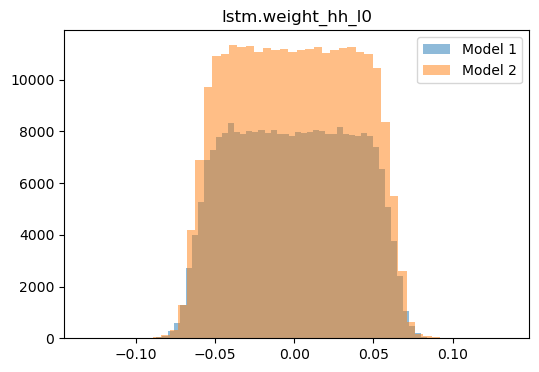

In [26]:
w1 = sd1["lstm.weight_hh_l0"].view(-1).cpu().numpy()  # flatten
w2 = sd2["lstm.weight_hh_l0"].view(-1).cpu().numpy()  # flatten
w3 = sd3["lstm.weight_hh_l0"].view(-1).cpu().numpy() #flatten
w4 = sd_avg["lstm.weight_hh_l0"].view(-1).cpu().numpy() #flatten
plt.figure(figsize=(6, 4))
plt.hist(w1, bins=50, alpha=0.5, label='Model 1')
plt.hist(w2, bins=50, alpha=0.5, label='Model 2')
# plt.hist(w3, bins=50, alpha=0.5, label='Model 3')
# plt.hist(w4, bins=50, alpha=0.5, label='Model AVG')
plt.legend()
plt.title("lstm.weight_hh_l0")
plt.show()

### Avg error FL123 dataset 1

In [27]:
avg_model.eval()
error = 0
n_sequences = len(test_tensor_seq_1)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_1[i]
    y_test_label = test_labels_1_un[i]
    y_pred_test = avg_model(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * first_piece.std().values + first_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.006037243409262737


### Avg error FL123 dataset 2

In [28]:
avg_model.eval()
error = 0
n_sequences = len(test_tensor_seq_2)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_2[i]
    y_test_label = test_labels_2_un[i]
    y_pred_test = avg_model(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * second_piece.std().values + second_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.005886397640767827


### Avg error FL123 dataset 3

In [29]:
avg_model.eval()
error = 0
n_sequences = len(test_tensor_seq_3)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_3[i]
    y_test_label = test_labels_3_un[i]
    y_pred_test = avg_model(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * third_piece.std().values + third_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.004887510934582061


### Avg error FL 123 dataset 4

In [30]:
avg_model.eval()
error = 0
n_sequences = len(test_tensor_seq_4)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_4[i]
    y_test_label = test_labels_4_un[i]
    y_pred_test = avg_model(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * fourth_piece.std().values + fourth_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.006128550056547317
